In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import wilcoxon
from scipy.optimize import minimize

from utils_file.tools import load_cache_file
from utils_file.finance_tools import *

warnings.filterwarnings("ignore")

path = "figure_file"

In [2]:
test_result = load_cache_file("pre-train-fixWindow/test_result_119.pkl")
test_result_reward = list(test_result["reward_result"].values())

## Comparison Target: Reduced S&P500 components

In [3]:
test_data = pd.read_csv("data_file/test_PT.csv")
tickers = test_data["Ticker"].unique()

In [ ]:
# 將個股的股價資料新增 Bollinger bands & daily log return
BB_value = []

for ticker in tickers:
    temp = test_data[test_data["Ticker"] == ticker]
    temp["ma_line"] = temp["Close"].rolling(window=5).mean()
    std = temp["Close"].rolling(window=5).std()
    temp["upper_bound"] = temp["ma_line"] + std
    temp["lower_bound"] = temp["ma_line"] - std
    temp["log_rtn"] = np.log(temp["Close"] / temp["Close"].shift(1))
    temp = temp.dropna()
    BB_value.append(temp)

test_append = pd.concat(BB_value, ignore_index=True)

In [5]:
# 將個股的股價資料按照每個月切割出來，並存於字典中
split_test = {}

unique_years = test_append["Year"].unique()
unique_months = test_append["Month"].unique()

idx = 1
for year in unique_years:
    for month in unique_months:
        split_test[f"state_{idx}"] = {}

        date_mask = (test_append["Year"] == year) & (test_append["Month"] == month)
        mask_table = test_append[date_mask]

        for ticker in tickers:
            split_test[f"state_{idx}"][ticker] = mask_table[
                mask_table["Ticker"] == ticker
            ]

        idx += 1

In [6]:
# 每一支成分股都執行一次自定義交易策略
trading_result_BB = {}

for state in list(split_test.keys()):
    all_ticker_reward = []

    for ticker in tickers:
        temp = split_test[state][ticker]

        ## 判斷是否建倉
        ub_open_flag = False
        lb_open_flag = False
        status_list = []

        for i, row in temp.iterrows():
            if row["Close"] > row["upper_bound"] and ub_open_flag is False:
                status_list.append("UB_open")
                ub_open_flag = True

            elif row["Close"] < row["ma_line"] and ub_open_flag is True:
                status_list.append("UB_close")
                ub_open_flag = False

            elif row["Close"] < row["lower_bound"] and lb_open_flag is False:
                status_list.append("LB_open")
                lb_open_flag = True

            elif row["Close"] > row["ma_line"] and lb_open_flag is True:
                status_list.append("LB_close")
                lb_open_flag = False

            else:
                status_list.append(0)

        status_list[-1] = "close"
        temp["status"] = status_list

        ## 實際執行交易策略結果
        reward_record = []
        UB_price = None
        LB_price = None

        for i, row in temp.iterrows():
            if row["status"] == "UB_open" and UB_price is None:
                UB_price = row["Close"]

            elif row["status"] == "LB_open" and LB_price is None:
                LB_price = row["Close"]

            elif row["status"] == "UB_close" and UB_price is not None:
                simple_return = (row["Close"] - UB_price) / UB_price
                reward_record.append(simple_return)
                UB_price = None

            elif row["status"] == "LB_close" and LB_price is not None:
                simple_return = -(row["Close"] - LB_price) / LB_price
                reward_record.append(simple_return)
                LB_price = None

            elif row["status"] == "close" and UB_price is not None:
                simple_return = (row["Close"] - UB_price) / UB_price
                reward_record.append(simple_return)

            elif row["status"] == "close" and LB_price is not None:
                simple_return = -(row["Close"] - LB_price) / LB_price
                reward_record.append(simple_return)

        all_ticker_reward.append(sum(reward_record))

    trading_result_BB[state] = all_ticker_reward

In [7]:
# 每一支成分股都執行一次 B&H 交易策略
trading_result_BandH = {}

for state in list(split_test.keys()):
    all_ticker_reward = []

    for ticker in tickers:
        all_ticker_reward.append(split_test[state][ticker]["log_rtn"].sum())

    trading_result_BandH[state] = all_ticker_reward

### Strategy: Bollinger Bands

In [8]:
trading_table_BB = pd.DataFrame(trading_result_BB)

above_median_x, above_median_y = [], []
below_median_x, below_median_y = [], []

for x, y in enumerate(trading_table_BB.median()):
    value = test_result_reward[x]

    if value > y:
        above_median_x.append(x + 1)
        above_median_y.append(value)

    else:
        below_median_x.append(x + 1)
        below_median_y.append(value)

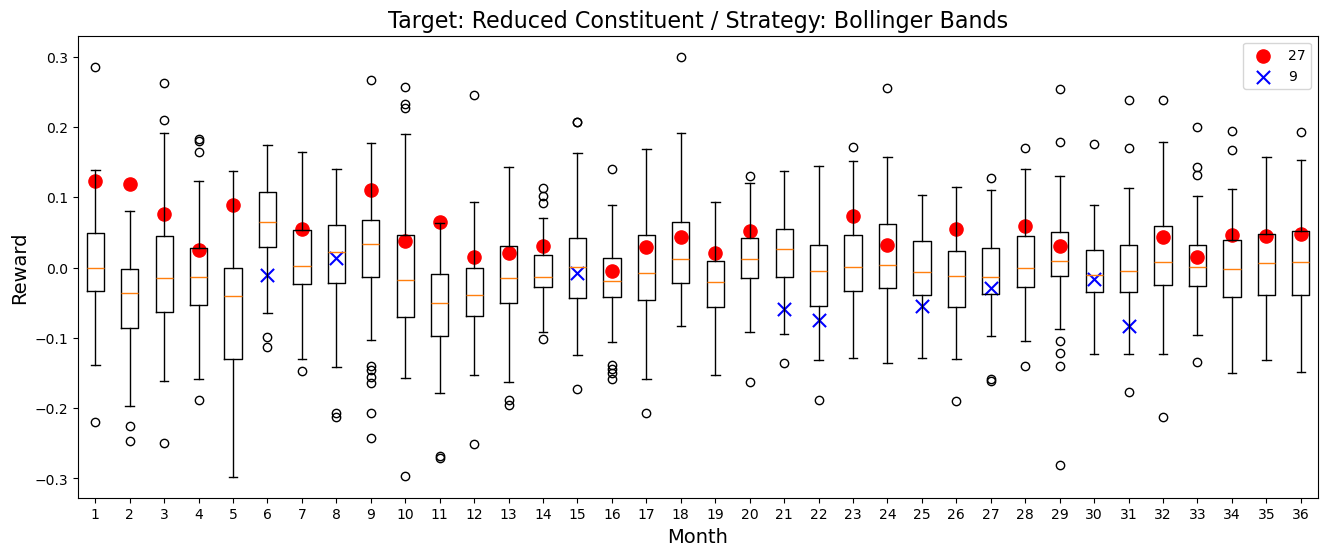

In [9]:
plt.figure(figsize=(16, 6))
plt.boxplot(trading_table_BB)
plt.scatter(
    above_median_x,
    above_median_y,
    s=90,
    color="red",
    marker="o",
    label=f"{len(above_median_x)}",
)
plt.scatter(
    below_median_x,
    below_median_y,
    s=90,
    color="blue",
    marker="x",
    label=f"{len(below_median_x)}",
)
plt.xlabel("Month", fontsize=14)
plt.ylabel("Reward", fontsize=14)
plt.legend()
plt.title("Target: Reduced Constituent / Strategy: Bollinger Bands", fontsize=16)
plt.show()

In [10]:
def rank_finder(target_list, comparison_table):
    result = []

    for i in range(len(target_list)):
        target = target_list[i]
        value = comparison_table[f"state_{i + 1}"].sort_values(ascending=False)
        rank = 1

        for j in value:
            if target <= j:
                rank += 1

        result.append(rank)

    return result

In [11]:
test_result_rank = rank_finder(test_result_reward, trading_table_BB)

trading_mean_BB = trading_table_BB.mean()
trading_mean_rank_BB = rank_finder(trading_mean_BB, trading_table_BB)

WRS = wilcoxon(test_result_rank, trading_mean_rank_BB, alternative="less")
print(f"p-value of WRS: {WRS[1]: .4f}")

p-value of WRS:  0.0032


[]

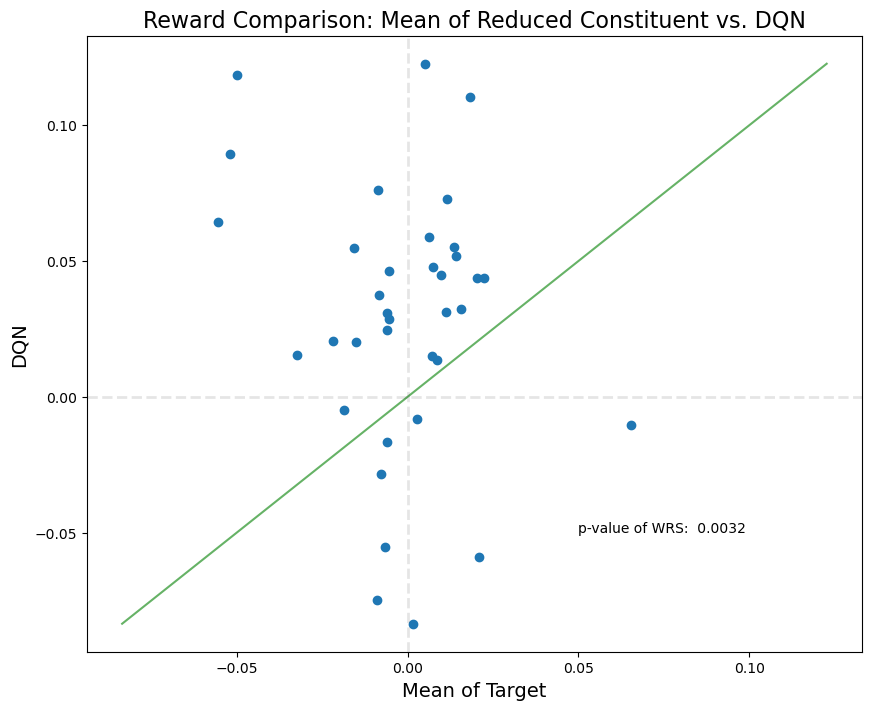

In [12]:
plt.figure(figsize=(10, 8))
plt.scatter(trading_mean_BB, test_result_reward)
plt.plot(
    np.linspace(
        min(min(trading_mean_BB), min(test_result_reward)),
        max(max(trading_mean_BB), max(test_result_reward)),
        200,
    ),
    np.linspace(
        min(min(trading_mean_BB), min(test_result_reward)),
        max(max(trading_mean_BB), max(test_result_reward)),
        200,
    ),
    color="green",
    alpha=0.6,
)
plt.axhline(y=0, color="black", linestyle="--", linewidth=2, alpha=0.1)
plt.axvline(x=0, color="black", linestyle="--", linewidth=2, alpha=0.1)
plt.xlabel("Mean of Target", fontsize=14)
plt.ylabel("DQN", fontsize=14)
plt.title("Reward Comparison: Mean of Reduced Constituent vs. DQN", fontsize=16)
plt.text(0.05, -0.05, f"p-value of WRS: {WRS[1]: .4f}")
plt.plot()

In [13]:
performance_indicators = pd.DataFrame(
    {
        "mean return": [
            mean_return(test_result_reward) * 100,
            mean_return(trading_mean_BB) * 100,
        ],
        "Sharpe ratio": [
            sharpe_ratio(test_result_reward),
            sharpe_ratio(trading_mean_BB),
        ],
        "Sortino ratio": [
            sortino_ratio(test_result_reward),
            sortino_ratio(trading_mean_BB),
        ],
        "profit factor": [
            profit_factor(test_result_reward),
            profit_factor(trading_mean_BB),
        ],
        "max drawdown": [
            max_drawdown(test_result_reward) * 100,
            max_drawdown(trading_mean_BB) * 100,
        ],
        "Calmar ratio": [
            calmar_ratio(test_result_reward),
            calmar_ratio(trading_mean_BB),
        ],
    },
    index=["DQN", "mean of reduced constituent (BB)"],
)

performance_indicators.T

,DQN,mean of reduced constituent (BB)
mean return,34.388875,-2.254552
Sharpe ratio,2.040049,-0.289170
Sortino ratio,3.443397,-0.388207
profit factor,4.023925,0.795331
max drawdown,-12.944664,-14.531040
Calmar ratio,2.656606,-0.155154


### Strategy: Buy and Hold

In [14]:
trading_table_BandH = pd.DataFrame(trading_result_BandH)

above_median_x, above_median_y = [], []
below_median_x, below_median_y = [], []

for x, y in enumerate(trading_table_BandH.median()):
    value = test_result_reward[x]

    if value > y:
        above_median_x.append(x + 1)
        above_median_y.append(value)

    else:
        below_median_x.append(x + 1)
        below_median_y.append(value)

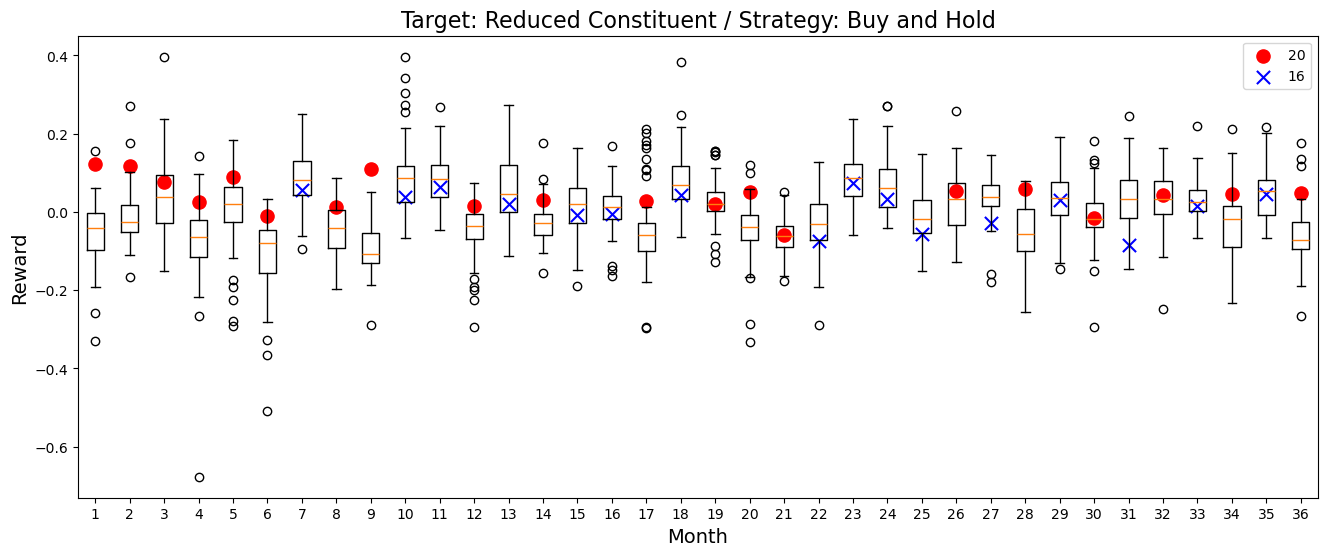

In [15]:
plt.figure(figsize=(16, 6))
plt.boxplot(trading_table_BandH)
plt.scatter(
    above_median_x,
    above_median_y,
    s=90,
    color="red",
    marker="o",
    label=f"{len(above_median_x)}",
)
plt.scatter(
    below_median_x,
    below_median_y,
    s=90,
    color="blue",
    marker="x",
    label=f"{len(below_median_x)}",
)
plt.xlabel("Month", fontsize=14)
plt.ylabel("Reward", fontsize=14)
plt.legend()
plt.title("Target: Reduced Constituent / Strategy: Buy and Hold", fontsize=16)
plt.show()

In [16]:
test_result_rank = rank_finder(test_result_reward, trading_table_BandH)

trading_mean_BandH = trading_table_BandH.mean()
trading_mean_rank_BandH = rank_finder(trading_mean_BandH, trading_table_BandH)

WRS = wilcoxon(test_result_rank, trading_mean_rank_BandH, alternative="less")
print(f"p-value of WRS: {WRS[1]: .4f}")

p-value of WRS:  0.0473


[]

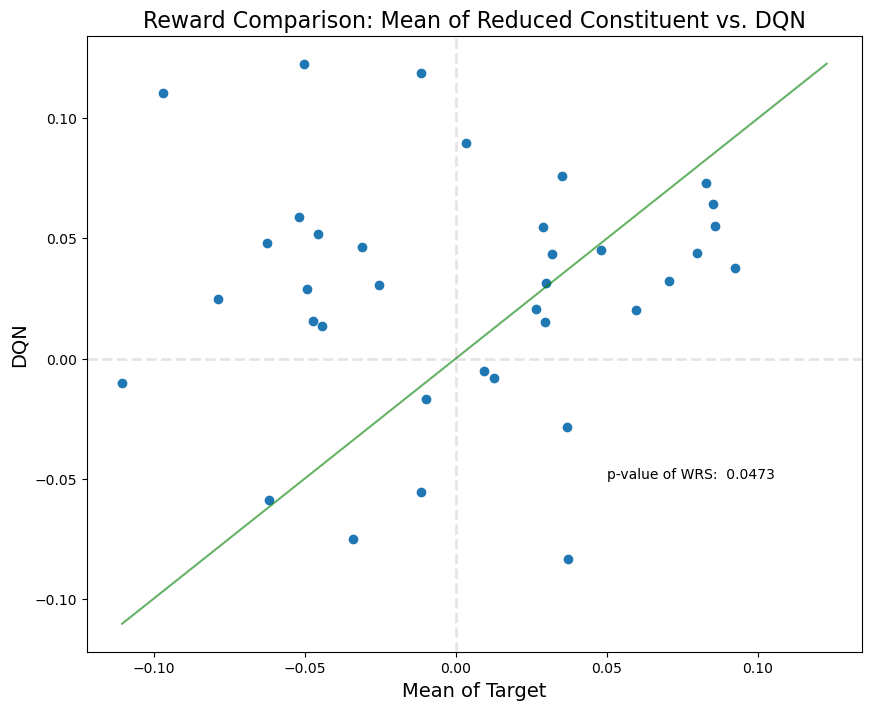

In [17]:
plt.figure(figsize=(10, 8))
plt.scatter(trading_mean_BandH, test_result_reward)
plt.plot(
    np.linspace(
        min(min(trading_mean_BandH), min(test_result_reward)),
        max(max(trading_mean_BandH), max(test_result_reward)),
        200,
    ),
    np.linspace(
        min(min(trading_mean_BandH), min(test_result_reward)),
        max(max(trading_mean_BandH), max(test_result_reward)),
        200,
    ),
    color="green",
    alpha=0.6,
)
plt.axhline(y=0, color="black", linestyle="--", linewidth=2, alpha=0.1)
plt.axvline(x=0, color="black", linestyle="--", linewidth=2, alpha=0.1)
plt.xlabel("Mean of Target", fontsize=14)
plt.ylabel("DQN", fontsize=14)
plt.title("Reward Comparison: Mean of Reduced Constituent vs. DQN", fontsize=16)
plt.text(0.05, -0.05, f"p-value of WRS: {WRS[1]: .4f}")
plt.plot()

In [18]:
performance_indicators = pd.DataFrame(
    {
        "mean return": [
            mean_return(test_result_reward) * 100,
            mean_return(trading_mean_BB) * 100,
            mean_return(trading_mean_BandH) * 100,
        ],
        "Sharpe ratio": [
            sharpe_ratio(test_result_reward),
            sharpe_ratio(trading_mean_BB),
            sharpe_ratio(trading_mean_BandH),
        ],
        "Sortino ratio": [
            sortino_ratio(test_result_reward),
            sortino_ratio(trading_mean_BB),
            sortino_ratio(trading_mean_BandH),
        ],
        "profit factor": [
            profit_factor(test_result_reward),
            profit_factor(trading_mean_BB),
            profit_factor(trading_mean_BandH),
        ],
        "max drawdown": [
            max_drawdown(test_result_reward) * 100,
            max_drawdown(trading_mean_BB) * 100,
            max_drawdown(trading_mean_BandH) * 100,
        ],
        "Calmar ratio": [
            calmar_ratio(test_result_reward),
            calmar_ratio(trading_mean_BB),
            calmar_ratio(trading_mean_BandH),
        ],
    },
    index=[
        "DQN",
        "mean of reduced components (BB)",
        "mean of reduced components (B&H)",
    ],
)

performance_indicators.T

,DQN,mean of reduced components (BB),mean of reduced components (B&H)
mean return,34.388875,-2.254552,2.074124
Sharpe ratio,2.040049,-0.289170,0.109252
Sortino ratio,3.443397,-0.388207,0.218103
profit factor,4.023925,0.795331,1.075694
max drawdown,-12.944664,-14.531040,-22.954331
Calmar ratio,2.656606,-0.155154,0.090359


## Comparison Target: S&P500 components

In [19]:
test_data = pd.read_csv("data_file/test.csv")
tickers = test_data["Ticker"].unique()

In [20]:
# 將個股的股價資料新增 Bollinger bands & daily log return
BB_value = []

for ticker in tickers:
    temp = test_data[test_data["Ticker"] == ticker]
    temp["ma_line"] = temp["Close"].rolling(window=5).mean()
    std = temp["Close"].rolling(window=5).std()
    temp["upper_bound"] = temp["ma_line"] + std
    temp["lower_bound"] = temp["ma_line"] - std
    temp["log_rtn"] = np.log(temp["Close"] / temp["Close"].shift(1))
    temp = temp.dropna()
    BB_value.append(temp)

test_append = pd.concat(BB_value, ignore_index=True)

In [21]:
# 將個股的股價資料按照每個月切割出來，並存於字典中
split_test = {}

unique_years = test_append["Year"].unique()
unique_months = test_append["Month"].unique()

idx = 1
for year in unique_years:
    for month in unique_months:
        split_test[f"state_{idx}"] = {}

        date_mask = (test_append["Year"] == year) & (test_append["Month"] == month)
        mask_table = test_append[date_mask]

        for ticker in tickers:
            split_test[f"state_{idx}"][ticker] = mask_table[
                mask_table["Ticker"] == ticker
            ]

        idx += 1

In [22]:
# 每一支成分股都執行一次自定義交易策略
trading_result_BB = {}

for state in list(split_test.keys()):
    all_ticker_reward = []

    for ticker in tickers:
        temp = split_test[state][ticker]

        ## 判斷是否建倉
        ub_open_flag = False
        lb_open_flag = False
        status_list = []

        for i, row in temp.iterrows():
            if row["Close"] > row["upper_bound"] and ub_open_flag is False:
                status_list.append("UB_open")
                ub_open_flag = True

            elif row["Close"] < row["ma_line"] and ub_open_flag is True:
                status_list.append("UB_close")
                ub_open_flag = False

            elif row["Close"] < row["lower_bound"] and lb_open_flag is False:
                status_list.append("LB_open")
                lb_open_flag = True

            elif row["Close"] > row["ma_line"] and lb_open_flag is True:
                status_list.append("LB_close")
                lb_open_flag = False

            else:
                status_list.append(0)

        status_list[-1] = "close"
        temp["status"] = status_list

        ## 實際執行交易策略結果
        reward_record = []
        UB_price = None
        LB_price = None

        for i, row in temp.iterrows():
            if row["status"] == "UB_open" and UB_price is None:
                UB_price = row["Close"]

            elif row["status"] == "LB_open" and LB_price is None:
                LB_price = row["Close"]

            elif row["status"] == "UB_close" and UB_price is not None:
                simple_return = (row["Close"] - UB_price) / UB_price
                reward_record.append(simple_return)
                UB_price = None

            elif row["status"] == "LB_close" and LB_price is not None:
                simple_return = -(row["Close"] - LB_price) / LB_price
                reward_record.append(simple_return)
                LB_price = None

            elif row["status"] == "close" and UB_price is not None:
                simple_return = (row["Close"] - UB_price) / UB_price
                reward_record.append(simple_return)

            elif row["status"] == "close" and LB_price is not None:
                simple_return = -(row["Close"] - LB_price) / LB_price
                reward_record.append(simple_return)

        all_ticker_reward.append(sum(reward_record))

    trading_result_BB[state] = all_ticker_reward

KeyboardInterrupt: 

In [ ]:
# 每一支成分股都執行一次 B&H 交易策略
trading_result_BandH = {}

for state in list(split_test.keys()):
    all_ticker_reward = []

    for ticker in tickers:
        all_ticker_reward.append(split_test[state][ticker]["log_rtn"].sum())

    trading_result_BandH[state] = all_ticker_reward

### Strategy: Bollinger Bands

In [ ]:
trading_table_BB = pd.DataFrame(trading_result_BB)

above_median_x, above_median_y = [], []
below_median_x, below_median_y = [], []

for x, y in enumerate(trading_table_BB.median()):
    value = test_result_reward[x]

    if value > y:
        above_median_x.append(x + 1)
        above_median_y.append(value)

    else:
        below_median_x.append(x + 1)
        below_median_y.append(value)

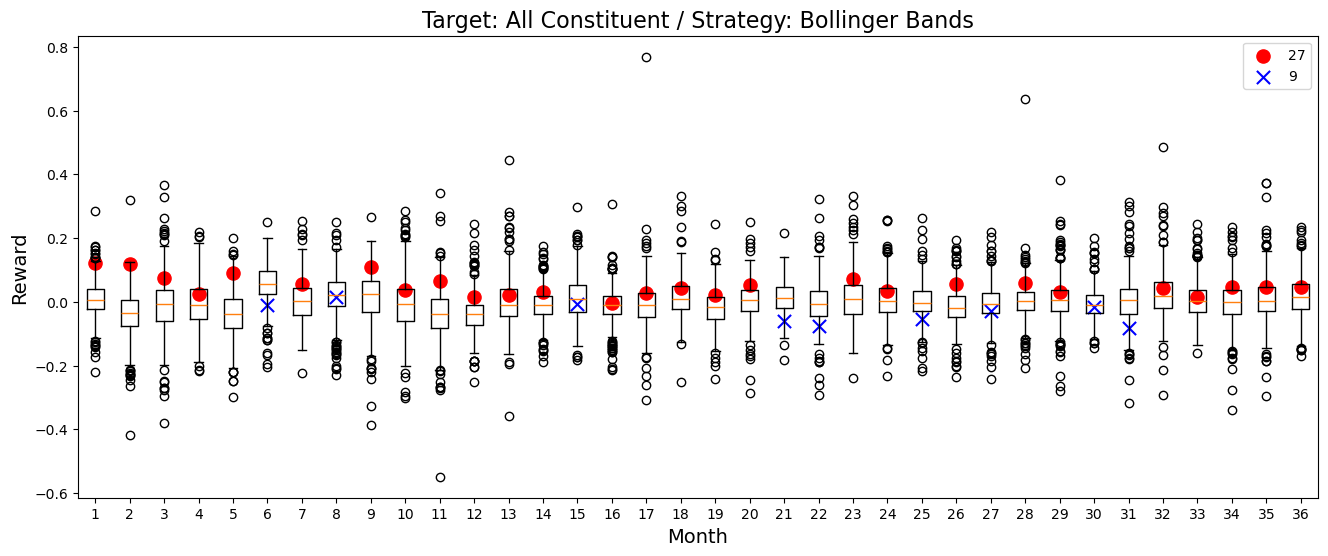

In [ ]:
plt.figure(figsize=(16, 6))
plt.boxplot(trading_table_BB)
plt.scatter(
    above_median_x,
    above_median_y,
    s=90,
    color="red",
    marker="o",
    label=f"{len(above_median_x)}",
)
plt.scatter(
    below_median_x,
    below_median_y,
    s=90,
    color="blue",
    marker="x",
    label=f"{len(below_median_x)}",
)
plt.xlabel("Month", fontsize=14)
plt.ylabel("Reward", fontsize=14)
plt.legend()
plt.title("Target: All Constituent / Strategy: Bollinger Bands", fontsize=16)
plt.show()

In [ ]:
test_result_rank = rank_finder(test_result_reward, trading_table_BB)

trading_mean_all_BB = trading_table_BB.mean()
trading_mean_all_rank_BB = rank_finder(trading_mean_all_BB, trading_table_BB)

WRS = wilcoxon(test_result_rank, trading_mean_all_rank_BB, alternative="less")
print(f"p-value of WRS: {WRS[1]: .4f}")

p-value of WRS:  0.0028


[]

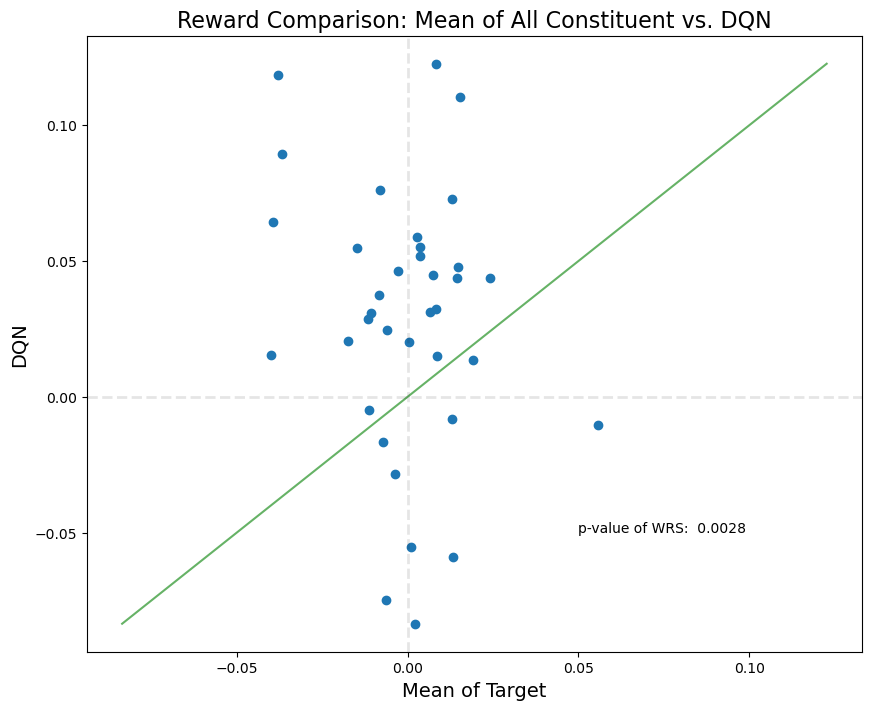

In [ ]:
plt.figure(figsize=(10, 8))
plt.scatter(trading_mean_all_BB, test_result_reward)
plt.plot(
    np.linspace(
        min(min(trading_mean_all_BB), min(test_result_reward)),
        max(max(trading_mean_all_BB), max(test_result_reward)),
        200,
    ),
    np.linspace(
        min(min(trading_mean_all_BB), min(test_result_reward)),
        max(max(trading_mean_all_BB), max(test_result_reward)),
        200,
    ),
    color="green",
    alpha=0.6,
)
plt.axhline(y=0, color="black", linestyle="--", linewidth=2, alpha=0.1)
plt.axvline(x=0, color="black", linestyle="--", linewidth=2, alpha=0.1)
plt.xlabel("Mean of Target", fontsize=14)
plt.ylabel("DQN", fontsize=14)
plt.title("Reward Comparison: Mean of All Constituent vs. DQN", fontsize=16)
plt.text(0.05, -0.05, f"p-value of WRS: {WRS[1]: .4f}")
plt.plot()

In [ ]:
performance_indicators = pd.DataFrame(
    {
        "mean return": [
            mean_return(test_result_reward) * 100,
            mean_return(trading_mean_BB) * 100,
            mean_return(trading_mean_BandH) * 100,
            mean_return(trading_mean_all_BB) * 100,
        ],
        "Sharpe ratio": [
            sharpe_ratio(test_result_reward),
            sharpe_ratio(trading_mean_BB),
            sharpe_ratio(trading_mean_BandH),
            sharpe_ratio(trading_mean_all_BB),
        ],
        "Sortino ratio": [
            sortino_ratio(test_result_reward),
            sortino_ratio(trading_mean_BB),
            sortino_ratio(trading_mean_BandH),
            sortino_ratio(trading_mean_all_BB),
        ],
        "profit factor": [
            profit_factor(test_result_reward),
            profit_factor(trading_mean_BB),
            profit_factor(trading_mean_BandH),
            profit_factor(trading_mean_all_BB),
        ],
        "max drawdown": [
            max_drawdown(test_result_reward) * 100,
            max_drawdown(trading_mean_BB) * 100,
            max_drawdown(trading_mean_BandH) * 100,
            max_drawdown(trading_mean_all_BB) * 100,
        ],
        "Calmar ratio": [
            calmar_ratio(test_result_reward),
            calmar_ratio(trading_mean_BB),
            calmar_ratio(trading_mean_BandH),
            calmar_ratio(trading_mean_all_BB),
        ],
    },
    index=[
        "DQN",
        "mean of reduced constituent (BB)",
        "mean of reduced constituent (B&H)",
        "mean of all constituent (BB)",
    ],
)

performance_indicators.T

,DQN,mean of reduced constituent (BB),mean of reduced constituent (B&H),mean of all constituent (BB)
mean return,34.388875,-2.254552,2.074124,-0.881902
Sharpe ratio,2.040049,-0.289170,0.109252,-0.135704
Sortino ratio,3.443397,-0.388207,0.218103,-0.191324
profit factor,4.023925,0.795331,1.075694,0.898974
max drawdown,-12.944664,-14.531040,-22.954331,-10.689382
Calmar ratio,2.656606,-0.155154,0.090359,-0.082503


### Strategy: Buy and Hold

In [ ]:
trading_table_BandH = pd.DataFrame(trading_result_BandH)

above_median_x, above_median_y = [], []
below_median_x, below_median_y = [], []

for x, y in enumerate(trading_table_BandH.median()):
    value = test_result_reward[x]

    if value > y:
        above_median_x.append(x + 1)
        above_median_y.append(value)

    else:
        below_median_x.append(x + 1)
        below_median_y.append(value)

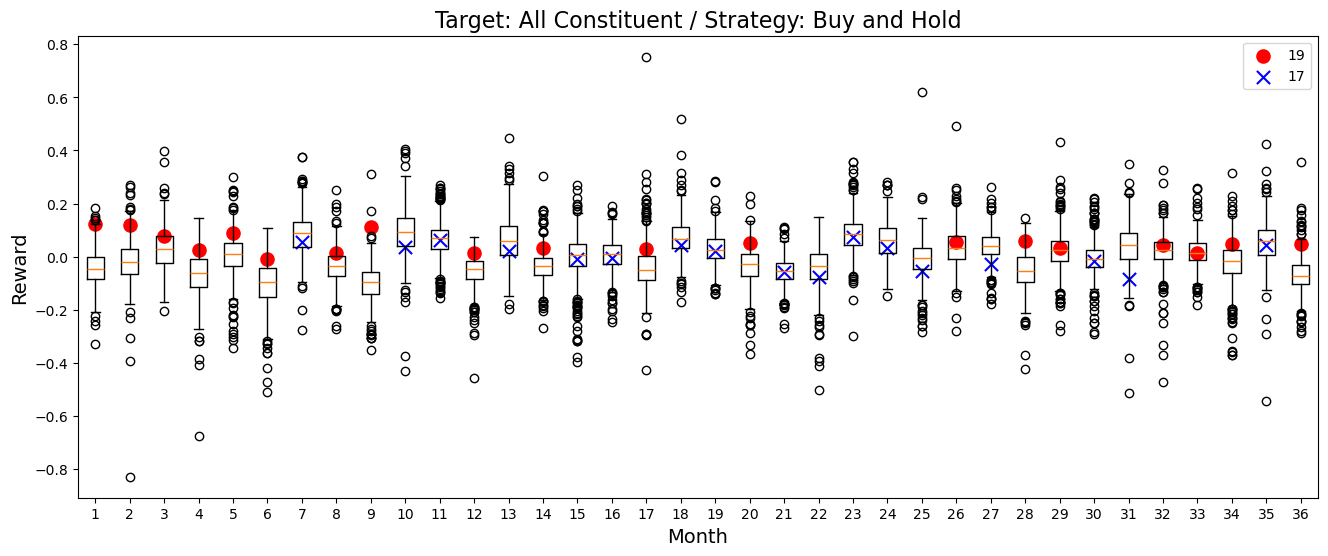

In [ ]:
plt.figure(figsize=(16, 6))
plt.boxplot(trading_table_BandH)
plt.scatter(
    above_median_x,
    above_median_y,
    s=90,
    color="red",
    marker="o",
    label=f"{len(above_median_x)}",
)
plt.scatter(
    below_median_x,
    below_median_y,
    s=90,
    color="blue",
    marker="x",
    label=f"{len(below_median_x)}",
)
plt.xlabel("Month", fontsize=14)
plt.ylabel("Reward", fontsize=14)
plt.legend()
plt.title("Target: All Constituent / Strategy: Buy and Hold", fontsize=16)
plt.show()

In [ ]:
test_result_rank = rank_finder(test_result_reward, trading_table_BandH)

trading_mean_all_BandH = trading_table_BandH.mean()
trading_mean_all_rank_BandH = rank_finder(trading_mean_all_BandH, trading_table_BandH)

WRS = wilcoxon(test_result_rank, trading_mean_all_rank_BandH, alternative="less")
print(f"p-value of WRS: {WRS[1]: .4f}")

p-value of WRS:  0.0346


[]

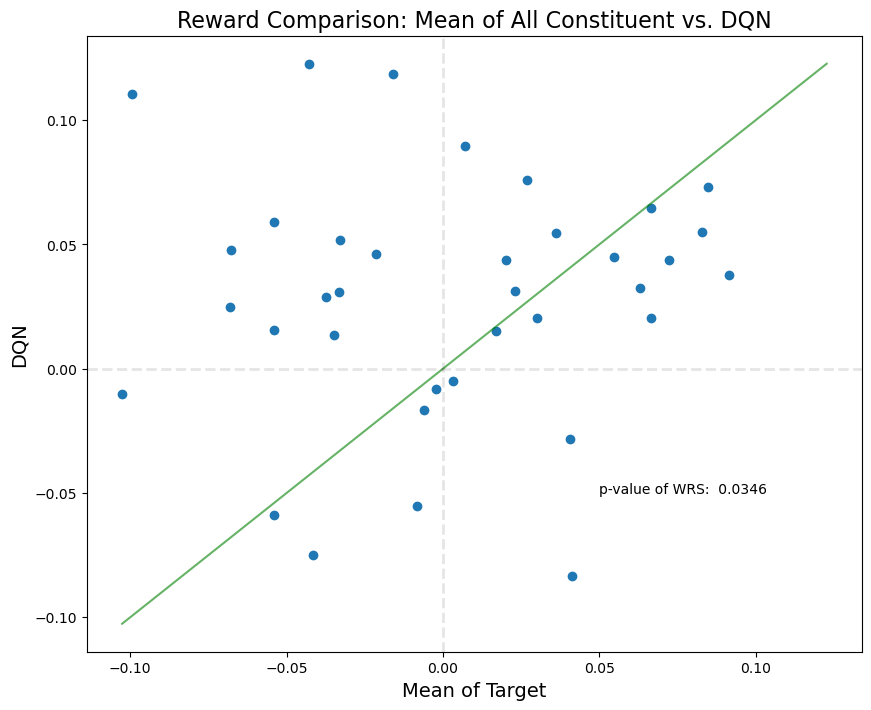

In [ ]:
plt.figure(figsize=(10, 8))
plt.scatter(trading_mean_all_BandH, test_result_reward)
plt.plot(
    np.linspace(
        min(min(trading_mean_all_BandH), min(test_result_reward)),
        max(max(trading_mean_all_BandH), max(test_result_reward)),
        200,
    ),
    np.linspace(
        min(min(trading_mean_all_BandH), min(test_result_reward)),
        max(max(trading_mean_all_BandH), max(test_result_reward)),
        200,
    ),
    color="green",
    alpha=0.6,
)
plt.axhline(y=0, color="black", linestyle="--", linewidth=2, alpha=0.1)
plt.axvline(x=0, color="black", linestyle="--", linewidth=2, alpha=0.1)
plt.xlabel("Mean of Target", fontsize=14)
plt.ylabel("DQN", fontsize=14)
plt.title("Reward Comparison: Mean of All Constituent vs. DQN", fontsize=16)
plt.text(0.05, -0.05, f"p-value of WRS: {WRS[1]: .4f}")
plt.plot()

In [ ]:
performance_indicators = pd.DataFrame(
    {
        "mean return": [
            mean_return(test_result_reward) * 100,
            mean_return(trading_mean_BB) * 100,
            mean_return(trading_mean_BandH) * 100,
            mean_return(trading_mean_all_BB) * 100,
            mean_return(trading_mean_all_BandH) * 100,
        ],
        "Sharpe ratio": [
            sharpe_ratio(test_result_reward),
            sharpe_ratio(trading_mean_BB),
            sharpe_ratio(trading_mean_BandH),
            sharpe_ratio(trading_mean_all_BB),
            sharpe_ratio(trading_mean_all_BandH),
        ],
        "Sortino ratio": [
            sortino_ratio(test_result_reward),
            sortino_ratio(trading_mean_BB),
            sortino_ratio(trading_mean_BandH),
            sortino_ratio(trading_mean_all_BB),
            sortino_ratio(trading_mean_all_BandH),
        ],
        "profit factor": [
            profit_factor(test_result_reward),
            profit_factor(trading_mean_BB),
            profit_factor(trading_mean_BandH),
            profit_factor(trading_mean_all_BB),
            profit_factor(trading_mean_all_BandH),
        ],
        "max drawdown": [
            max_drawdown(test_result_reward) * 100,
            max_drawdown(trading_mean_BB) * 100,
            max_drawdown(trading_mean_BandH) * 100,
            max_drawdown(trading_mean_all_BB) * 100,
            max_drawdown(trading_mean_all_BandH) * 100,
        ],
        "Calmar ratio": [
            calmar_ratio(test_result_reward),
            calmar_ratio(trading_mean_BB),
            calmar_ratio(trading_mean_BandH),
            calmar_ratio(trading_mean_all_BB),
            calmar_ratio(trading_mean_all_BandH),
        ],
    },
    index=[
        "DQN",
        "mean of reduced constituent (BB)",
        "mean of reduced constituent (B&H)",
        "mean of all constituent (BB)",
        "mean of all constituent (B&H)",
    ],
)

performance_indicators.T

,DQN,mean of reduced constituent (BB),mean of reduced constituent (B&H),mean of all constituent (BB),mean of all constituent (B&H)
mean return,34.388875,-2.254552,2.074124,-0.881902,1.705188
Sharpe ratio,2.040049,-0.289170,0.109252,-0.135704,0.094054
Sortino ratio,3.443397,-0.388207,0.218103,-0.191324,0.176017
profit factor,4.023925,0.795331,1.075694,0.898974,1.065850
max drawdown,-12.944664,-14.531040,-22.954331,-10.689382,-20.738508
Calmar ratio,2.656606,-0.155154,0.090359,-0.082503,0.082223


In [ ]:
performance_indicators.T.to_csv("performance.csv", index=True)

## Comparison Target: Tangency Portfolio generated by reduced components

In [19]:
train_data = pd.read_csv("data_file/train_PT.csv")
tickers = train_data["Ticker"].unique()

In [20]:
train_returns = pd.DataFrame(
    {
        ticker: np.log(
            train_data[train_data["Ticker"] == ticker]["Close"]
            / train_data[train_data["Ticker"] == ticker]["Close"].shift(1)
        )
        .dropna()
        .tolist()
        for ticker in tickers
    },
    index=train_data["Date"].unique()[1:],
)

In [28]:
# 1. 基本參數設定
mean_returns = train_returns.mean()
cov_matrix = train_returns.cov()
rf = 0


# 2. 投資組合夏普比率（Sharpe ratio）
def Sharpe_ratio(weights, mean_returns, cov_matrix, rf):
    port_return = np.dot(weights, mean_returns)
    port_std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return -(port_return - rf) / port_std


# 3. 條件與限制
num_assets = len(mean_returns)
init_guess = num_assets * [1.0 / num_assets]  # 初始均等權重
bounds = tuple((0, 1) for _ in range(num_assets))  # 權重在 [0,1] 範圍
constraints = {"type": "eq", "fun": lambda x: np.sum(x) - 1}  # 權重總和為 1

# 4. 最佳化
result = minimize(
    Sharpe_ratio,
    init_guess,
    args=(mean_returns, cov_matrix, rf),
    method="SLSQP",
    bounds=bounds,
    constraints=constraints,
)

# 5. 結果輸出
tangency_weights = result.x
print("Tangency portfolio weights:")
pd.set_option("display.max_rows", 100)
pd.Series(tangency_weights, index=train_returns.columns).sort_values()

Tangency portfolio weights:


AMCR    0.000000e+00
TFX     0.000000e+00
UHS     0.000000e+00
SO      0.000000e+00
SPG     0.000000e+00
SHW     0.000000e+00
NOW     0.000000e+00
RCL     0.000000e+00
ZBH     0.000000e+00
O       0.000000e+00
PSA     0.000000e+00
PEG     0.000000e+00
VZ      0.000000e+00
TSCO    0.000000e+00
WYNN    0.000000e+00
UDR     0.000000e+00
YUM     0.000000e+00
CDW     0.000000e+00
ED      0.000000e+00
EOG     0.000000e+00
MOS     0.000000e+00
EQT     0.000000e+00
KLAC    0.000000e+00
EXPD    0.000000e+00
WTW     7.311527e-20
MSI     1.472766e-18
VTR     2.922068e-18
REG     3.254417e-18
PNW     6.136530e-18
WAT     6.879615e-18
VMC     7.140066e-18
DHI     8.857897e-18
XYL     1.042962e-17
SJM     1.255764e-17
WMT     1.428993e-17
ULTA    1.616736e-17
TER     1.647205e-17
BBY     1.770235e-17
LRCX    1.785167e-17
RL      1.835710e-17
WBA     2.027490e-17
XEL     2.377337e-17
RMD     3.139272e-17
RVTY    3.185396e-17
NCLH    3.239365e-17
WELL    3.287059e-17
WEC     3.356152e-17
NI      3.652

In [22]:
test_data = pd.read_csv("data_file/test_PT.csv")
tickers = test_data["Ticker"].unique()

In [23]:
returns = pd.DataFrame(
    {
        ticker: np.log(
            test_data[test_data["Ticker"] == ticker]["Close"]
            / test_data[test_data["Ticker"] == ticker]["Close"].shift(1)
        )
        .dropna()
        .tolist()
        for ticker in tickers
    }
)

returns = pd.DataFrame({"log_rtn": returns.dot(tangency_weights)})
returns["Year"] = test_data[test_data["Ticker"] == "AMCR"]["Year"]
returns["Month"] = test_data[test_data["Ticker"] == "AMCR"]["Month"]

In [24]:
split_test_portfolio = {}

unique_years = returns["Year"].unique()
unique_months = returns["Month"].unique()

idx = 1
for year in unique_years:
    for month in unique_months:
        split_test_portfolio[f"state_{idx}"] = {}

        date_mask = (returns["Year"] == year) & (returns["Month"] == month)
        mask_table = returns[date_mask]

        for ticker in tickers:
            split_test_portfolio[f"state_{idx}"] = mask_table

        idx += 1

In [25]:
trading_result_BandH_portfolio = {}

for state in list(split_test_portfolio.keys()):
    all_ticker_reward = []

    all_ticker_reward.append(split_test_portfolio[state]["log_rtn"].sum())

    trading_result_BandH_portfolio[state] = all_ticker_reward

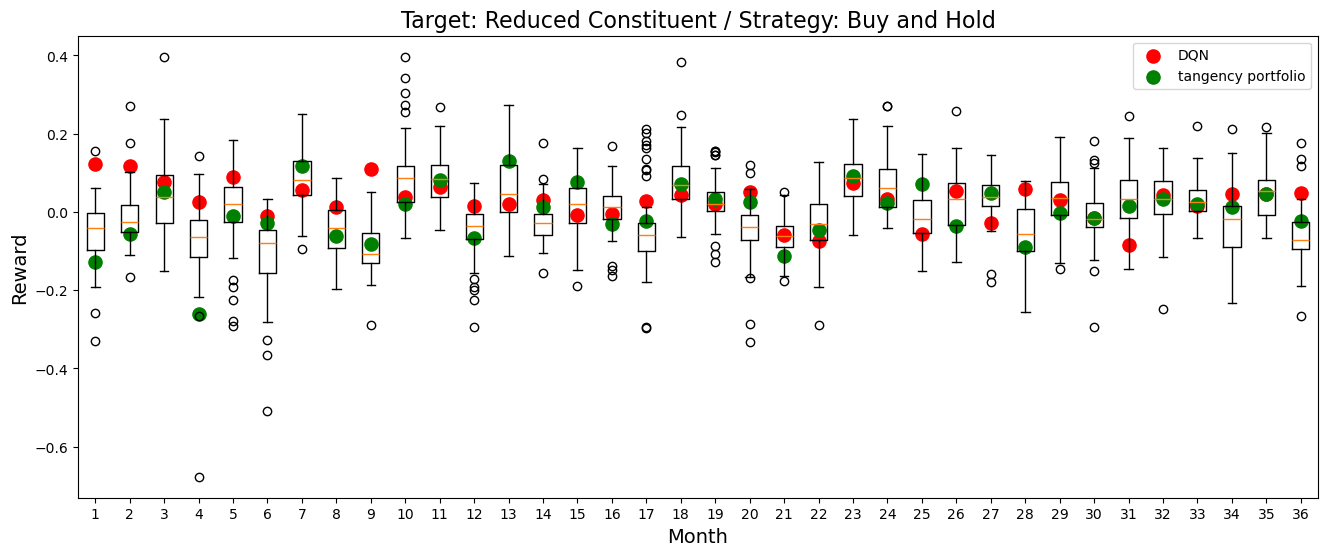

In [26]:
plt.figure(figsize=(16, 6))
plt.boxplot(trading_table_BandH)
plt.scatter(above_median_x, above_median_y, s=90, color="red", marker="o", label="DQN")
plt.scatter(below_median_x, below_median_y, s=90, color="red", marker="o")
plt.scatter(
    range(1, 37),
    trading_result_BandH_portfolio.values(),
    s=90,
    color="green",
    marker="o",
    label="tangency portfolio",
)
plt.xlabel("Month", fontsize=14)
plt.ylabel("Reward", fontsize=14)
plt.legend()
plt.title("Target: Reduced Constituent / Strategy: Buy and Hold", fontsize=16)
plt.show()

In [27]:
test_result_rank = rank_finder(test_result_reward, trading_table_BandH)
temp = []
for x in trading_result_BandH_portfolio.values():
    temp.append(x[0])
trading_mean_rank_BandH_port = rank_finder(temp, trading_table_BandH)

WRS = wilcoxon(test_result_rank, trading_mean_rank_BandH_port, alternative="less")
print(f"p-value of WRS: {WRS[1]: .4f}")

p-value of WRS:  0.0560


[]

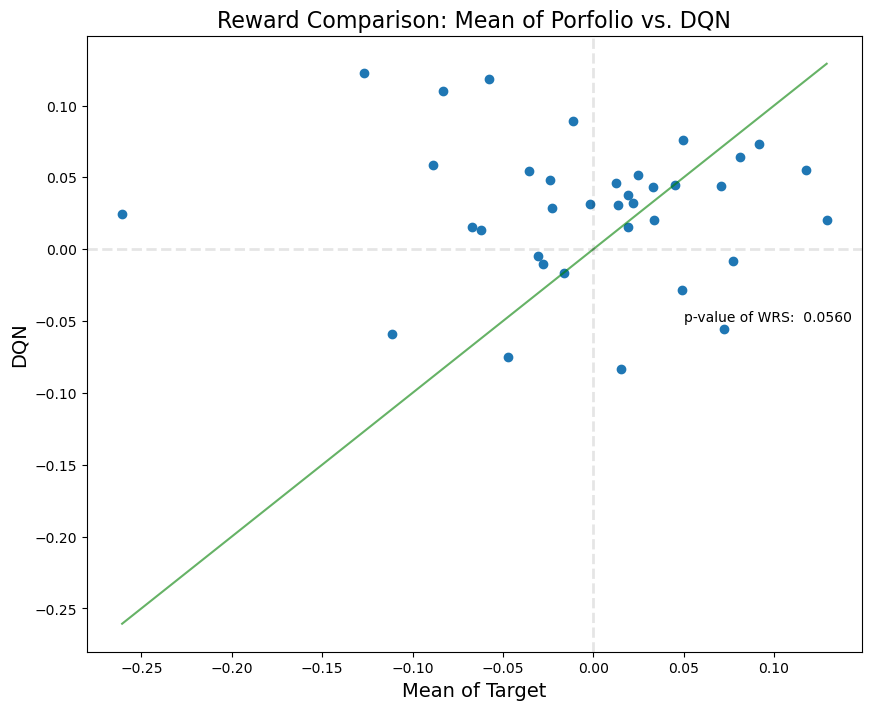

In [28]:
plt.figure(figsize=(10, 8))
plt.scatter(temp, test_result_reward)
plt.plot(
    np.linspace(
        min(min(temp), min(test_result_reward)),
        max(max(temp), max(test_result_reward)),
        200,
    ),
    np.linspace(
        min(min(temp), min(test_result_reward)),
        max(max(temp), max(test_result_reward)),
        200,
    ),
    color="green",
    alpha=0.6,
)
plt.axhline(y=0, color="black", linestyle="--", linewidth=2, alpha=0.1)
plt.axvline(x=0, color="black", linestyle="--", linewidth=2, alpha=0.1)
plt.xlabel("Mean of Target", fontsize=14)
plt.ylabel("DQN", fontsize=14)
plt.title("Reward Comparison: Mean of Porfolio vs. DQN", fontsize=16)
plt.text(0.05, -0.05, f"p-value of WRS: {WRS[1]: .4f}")
plt.plot()

In [30]:
performance_indicators = pd.DataFrame(
    {
        "mean return": [
            mean_return(test_result_reward) * 100,
            mean_return(trading_mean_BB) * 100,
            mean_return(temp) * 100,
        ],
        "Sharpe ratio": [
            sharpe_ratio(test_result_reward),
            sharpe_ratio(trading_mean_BB),
            sharpe_ratio(temp),
        ],
        "Sortino ratio": [
            sortino_ratio(test_result_reward),
            sortino_ratio(trading_mean_BB),
            sortino_ratio(temp),
        ],
        "profit factor": [
            profit_factor(test_result_reward),
            profit_factor(trading_mean_BB),
            profit_factor(temp),
        ],
        "max drawdown": [
            max_drawdown(test_result_reward) * 100,
            max_drawdown(trading_mean_BB) * 100,
            max_drawdown(temp) * 100,
        ],
        "Calmar ratio": [
            calmar_ratio(test_result_reward),
            calmar_ratio(trading_mean_BB),
            calmar_ratio(temp),
        ],
    },
    index=[
        "DQN",
        "mean of reduced constituent (BB)",
        "portfolio of reduced constituent",
    ],
)

performance_indicators.T

,DQN,mean of reduced constituent (BB),portfolio of reduced constituent
mean return,34.388875,-2.254552,-3.274296
Sharpe ratio,2.040049,-0.289170,-0.125983
Sortino ratio,3.443397,-0.388207,-0.156871
profit factor,4.023925,0.795331,0.908636
max drawdown,-12.944664,-14.531040,-32.427137
Calmar ratio,2.656606,-0.155154,-0.100974
